In [90]:
#libraries
import pandas as pd
import numpy as np
from numpy import column_stack
from xgboost import XGBClassifier
from xgboost import plot_tree
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from scipy import stats
from time import time
import matplotlib.pyplot as plt
from xgboost import plot_importance
import re
from scipy import sparse
from datetime import datetime
import pickle
import seaborn as sns

In [91]:
n_threads = 36
#set random_seed for reproduction purposes..
random_seed = 10

In [92]:
#convert date to seperate values for day, month, hour
def convert_date_to_day(dt):

   result = re.findall(r'\d{4}-(\d{2})-(\d{2})T00:00:00.000',dt)

   return result[0][1]

   

def convert_date_to_month(dt):

   result = re.findall(r'\d{4}-(\d{2})-(\d{2})T00:00:00.000',dt)

   return result[0][0]


def convert_date_to_year(dt):
    
    result = re.findall(r'(\d{4})-(\d{2})-(\d{2})T00:00:00.000',dt)

    return result[0][0]

def convert_time_to_hour(tm):

   result = re.findall(r'(\d{2}):\d{2}',tm)

   return result[0]


In [93]:
df_district = pd.read_csv('/home/ubuntu/CSVs/CITY_data.csv') #change this city for csv for whatever district being done

#added content...
#leave pddistrict in... need to label and OHE it

df_district = df_district.drop(columns=['incidntnum', 'pdid', 'location', 'descript'])
df_y = df_district['category']
df_x = df_district.drop(columns=['category'])
labelencoder = LabelEncoder()
labelencoder = labelencoder.fit(df_y)
labelencoded_y = labelencoder.transform(df_y)
df_x['day'] = df_x.date.apply(lambda x: convert_date_to_day(x))
df_x['month'] = df_x.date.apply(lambda x: convert_date_to_month(x))
df_x['year'] = df_x.date.apply(lambda x: convert_date_to_year(x))
df_x['hour'] = df_x.time.apply(lambda x: convert_time_to_hour(x))
df_x = df_x.drop(columns=['date', 'time'])
df_x['day'] = (df_x['day']).astype(int)
df_x['month'] = (df_x['month']).astype(int)
df_x['year'] = (df_x['year']).astype(int)
df_x['hour'] = (df_x['hour']).astype(int)
label_encoder_pddist = LabelEncoder()
pddistrict_feature = label_encoder_pddist.fit_transform(df_x.pddistrict.iloc[:].values)
pddistrict_feature = pddistrict_feature.reshape(df_x.shape[0], 1)
onehot_encoder_pdd = OneHotEncoder(sparse = False)
pddistrict_feature = onehot_encoder_pdd.fit_transform(pddistrict_feature)



In [94]:
type(pddistrict_feature)

numpy.ndarray

In [95]:
pddistrict_feature.shape

(2206399, 11)

In [96]:
label_encoder_addr = LabelEncoder()
addr_feature = label_encoder_addr.fit_transform(df_x.address.iloc[:].values)
addr_feature = addr_feature.reshape(df_x.shape[0], 1)
onehot_encoder_addr = OneHotEncoder(sparse = True)
onehot_encoder_addr = onehot_encoder_addr.fit(addr_feature)
addr_feature = onehot_encoder_addr.transform(addr_feature)

In [97]:
type(addr_feature)

scipy.sparse.csr.csr_matrix

In [98]:
addr_feature.shape

(2206399, 25140)

In [99]:
#addr_feature.toarray()

In [100]:

label_encoder_DoW = LabelEncoder()
DoW_feature = label_encoder_DoW.fit_transform(df_x.dayofweek.iloc[:].values)
DoW_feature = DoW_feature.reshape(df_x.shape[0], 1)
onehot_encoder_DoW = OneHotEncoder(sparse = False)
DoW_feature = onehot_encoder_DoW.fit_transform(DoW_feature)
label_encoder_res = LabelEncoder()
res_feature = label_encoder_res.fit_transform(df_x.resolution.iloc[:].values)
res_feature = res_feature.reshape(df_x.shape[0], 1)
onehot_encoder_res = OneHotEncoder(sparse = False)
res_feature = onehot_encoder_res.fit_transform(res_feature)

day = df_x.day.values
month = df_x.month.values
year = df_x.year.values
hour = df_x.hour.values
x = df_x.x.values

In [101]:

y = df_x.y.values

columns = []
#columns.append(addr_feature)
columns.append(DoW_feature)
columns.append(res_feature)
columns.append(pddistrict_feature)
columns.append(x)
columns.append(y)
columns.append(day)
columns.append(month)
columns.append(year)
columns.append(hour)
encoded_feats = column_stack(columns)
#sparse_features = sparse.csr_matrix(encoded_feats)

In [102]:
encoded_feats.shape

(2206399, 41)

In [103]:
sparse_test = sparse.hstack((encoded_feats,addr_feature))

In [104]:
type(sparse_test)

scipy.sparse.coo.coo_matrix

In [105]:
sparse_test.shape

(2206399, 25181)

In [106]:
X_train, X_test, y_train, y_test = train_test_split(sparse_test, labelencoded_y, test_size=0.20, random_state=random_seed)

model = XGBClassifier(nthread = n_threads) #or -1
kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=random_seed)
param_grid = {'n_estimators': [120, 240, 368, 480], #random int btwn 100 and 500 - removed
              'learning_rate': stats.uniform(0.01, 0.08), #.01 + loc, range of .01+/-.08
              'max_depth': [2, 4, 6, 8], #tree depths to check
              'colsample_bytree': stats.uniform(0.3, 0.7) #btwn .1 and 1.0    
}
rand_search = RandomizedSearchCV(model, param_distributions = param_grid, scoring = 'f1_micro', n_iter = 3, n_jobs=-1, verbose = 10, cv=kfold)
rand_result = rand_search.fit(X_train, y_train)
print("Best: %f using %s" % (rand_result.best_score_, rand_result.best_params_))
best_XGB_parameters = rand_result.best_estimator_
#INSERT CITY NAME FOR .DAT FILE
pickle.dump(best_XGB_parameters, open("xgb_CITY.pickle.dat", 'wb')) #change pickle



Fitting 3 folds for each of 3 candidates, totalling 9 fits
[CV] n_estimators=240, learning_rate=0.07479638183675186, colsample_bytree=0.7980509755593868, max_depth=4 
[CV] n_estimators=240, learning_rate=0.07479638183675186, colsample_bytree=0.7980509755593868, max_depth=4 
[CV] n_estimators=240, learning_rate=0.07479638183675186, colsample_bytree=0.7980509755593868, max_depth=4 
[CV] n_estimators=120, learning_rate=0.06141829094212287, colsample_bytree=0.5276686618562294, max_depth=4 
[CV] n_estimators=120, learning_rate=0.06141829094212287, colsample_bytree=0.5276686618562294, max_depth=4 
[CV] n_estimators=120, learning_rate=0.06141829094212287, colsample_bytree=0.5276686618562294, max_depth=4 
[CV] n_estimators=240, learning_rate=0.08040707535403382, colsample_bytree=0.9999383201516157, max_depth=8 
[CV] n_estimators=240, learning_rate=0.08040707535403382, colsample_bytree=0.9999383201516157, max_depth=8 
[CV] n_estimators=240, learning_rate=0.08040707535403382, colsample_bytree=0.

/home/ubuntu/anaconda2/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ubuntu/anaconda2/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ubuntu/anaconda2/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ubuntu/anaconda2/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is a

[CV]  n_estimators=120, learning_rate=0.06141829094212287, colsample_bytree=0.5276686618562294, max_depth=4, score=0.361964118183, total=135.5min


/home/ubuntu/anaconda2/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  n_estimators=120, learning_rate=0.06141829094212287, colsample_bytree=0.5276686618562294, max_depth=4, score=0.361335925736, total=136.6min


[Parallel(n_jobs=-1)]: Done   2 out of   9 | elapsed: 140.2min remaining: 490.5min
/home/ubuntu/anaconda2/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  n_estimators=120, learning_rate=0.06141829094212287, colsample_bytree=0.5276686618562294, max_depth=4, score=0.362472104522, total=137.0min


[Parallel(n_jobs=-1)]: Done   3 out of   9 | elapsed: 140.5min remaining: 281.0min
/home/ubuntu/anaconda2/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ubuntu/anaconda2/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ubuntu/anaconda2/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ubuntu/anaconda2/lib/python2.7/site-packages/sklearn/pre

[CV]  n_estimators=240, learning_rate=0.07479638183675186, colsample_bytree=0.7980509755593868, max_depth=4, score=0.368589133479, total=243.8min


[Parallel(n_jobs=-1)]: Done   4 out of   9 | elapsed: 248.7min remaining: 310.9min
/home/ubuntu/anaconda2/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  n_estimators=240, learning_rate=0.07479638183675186, colsample_bytree=0.7980509755593868, max_depth=4, score=0.367415268208, total=243.6min


[Parallel(n_jobs=-1)]: Done   5 out of   9 | elapsed: 248.8min remaining: 199.0min
/home/ubuntu/anaconda2/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  n_estimators=240, learning_rate=0.07479638183675186, colsample_bytree=0.7980509755593868, max_depth=4, score=0.368510955083, total=248.2min


[Parallel(n_jobs=-1)]: Done   6 out of   9 | elapsed: 252.0min remaining: 126.0min
/home/ubuntu/anaconda2/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ubuntu/anaconda2/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ubuntu/anaconda2/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ubuntu/anaconda2/lib/python2.7/site-packages/sklearn/pre

[CV]  n_estimators=240, learning_rate=0.08040707535403382, colsample_bytree=0.9999383201516157, max_depth=8, score=0.379482185136, total=336.6min


[Parallel(n_jobs=-1)]: Done   7 out of   9 | elapsed: 345.3min remaining: 98.6min
/home/ubuntu/anaconda2/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  n_estimators=240, learning_rate=0.08040707535403382, colsample_bytree=0.9999383201516157, max_depth=8, score=0.378856736904, total=336.7min


/home/ubuntu/anaconda2/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  n_estimators=240, learning_rate=0.08040707535403382, colsample_bytree=0.9999383201516157, max_depth=8, score=0.379658585666, total=340.1min


[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed: 346.1min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed: 346.1min finished


Best: 0.379332 using {'n_estimators': 240, 'learning_rate': 0.08040707535403382, 'colsample_bytree': 0.9999383201516157, 'max_depth': 8}


In [109]:
#test on test set
best_XGB_parameters.fit(X_train, y_train)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.9999383201516157, gamma=0,
       learning_rate=0.08040707535403382, max_delta_step=0, max_depth=8,
       min_child_weight=1, missing=None, n_estimators=240, n_jobs=1,
       nthread=36, objective='multi:softprob', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
       subsample=1)

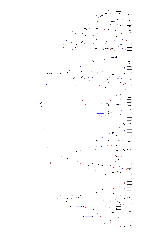

/home/ubuntu/anaconda2/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [111]:
preds = best_XGB_parameters.predict(X_test)
f1score = f1_score(y_test, preds, average = 'micro')
#CSV append best score after test set
f1_score = []
f1_score.append(('City', f1score))
export_df = pd.DataFrame(f1_score)
#change csv name
export_df.to_csv("cityresults.dat", index = False, header = False)

In [156]:
#add code for graphing each parameter from cv search...
#https://stackoverflow.com/questions/42793254/what-replaces-gridsearchcv-grid-scores-in-scikit

param_scores = rand_result.cv_results_['mean_test_score']


In [165]:
param_list = rand_result.cv_results_['params']

In [180]:
colsamples = [param_list[0]['colsample_bytree'],param_list[1]['colsample_bytree'],param_list[2]['colsample_bytree']]
learnrate = [param_list[0]['learning_rate'],param_list[1]['learning_rate'],param_list[2]['learning_rate']]
maxdepth = [param_list[0]['max_depth'],param_list[1]['max_depth'],param_list[2]['max_depth']]
estimators = [param_list[0]['n_estimators'],param_list[1]['n_estimators'],param_list[2]['n_estimators']]

In [167]:
model_names = ['RS1', 'RS2', 'RS3']

In [181]:
rscv_scores = pd.DataFrame()
rscv_scores['Model Name'] = model_names
rscv_scores['Scores'] = param_scores
rscv_scores['col_samplesbytree'] = colsamples
rscv_scores['learning_rates'] = learnrate
rscv_scores['max_depths'] = maxdepth
rscv_scores['# estimators'] = estimators

In [182]:
rscv_scores
#used this in jupyter notebook to create visible table to put in report

,Model Name,Scores,col_samplesbytree,learning_rates,max_depths,# estimators
0,RS1,0.368172,0.798051,0.074796,4,240
1,RS2,0.361924,0.527669,0.061418,4,120
2,RS3,0.379332,0.999938,0.080407,8,240


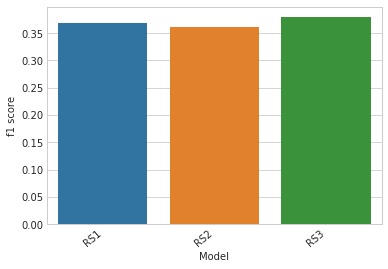

In [183]:
sns.set_style("whitegrid")
#might need to convert data from list to pandas DF..
#try above first
msplt = sns.barplot(x = "Model Name", y = "Scores", data=rscv_scores)
msplt.set_xticklabels(msplt.get_xticklabels(), rotation =40, ha="right")
_ = plt.xlabel('Model')
_ = plt.ylabel('f1 score')
_ = plt.savefig('parameter_comparisons')
_ = plt.show()